In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Standard libraries

import math
import os
import sys

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

# Scikit-learn
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Keras
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Conv1D, Dropout, Activation, Flatten
from keras.metrics import AUC
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import Sequence

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from utils import split_train_val_test, load_X_y

# Local imports
from models import Attia_et_al_CNN

# Environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

/tmp/ipykernel_636907/2303156449.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-04-23 09:43:43.390561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 09:43:43.390588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 09:43:43.391626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unabl

In [3]:
OUTCOME = 'STDD'

In [4]:
conditions = ['1AVB', 'AF', 'AFIB', 'APB', 'AQW', 'IDC',
              'LVH', 'LVQRSAL', 'RBBB', 'SR', 'ST',
              'STDD', 'STE', 'STTC', 'SVT', 'TWC',
              'TWO']

from utils import mapping


data_df = pd.read_pickle('data/arrythmia_dataset.pickle')

X, y = data_df['wf'].to_numpy(), data_df[conditions].to_numpy()
y = y.astype(float)
X = np.stack(X, axis=0)

del data_df

X_train, X_val, X_test_int, y_train, y_val, y_test_int = split_train_val_test(X, y, train_size=0.7, val_size=0.15)
del X, y, X_train, y_train, X_val, y_val


data_df = pd.read_pickle('data/ptb-xl_dataset.pickle')
conditions_ext = [mapping[key] for key in mapping.keys()]

X_ext, y_ext = data_df['wf'].to_numpy(), data_df[conditions_ext].to_numpy()
y_ext = y_ext.astype(float)
X_ext = np.stack(X_ext, axis=0)

outcome_idx = conditions.index(OUTCOME)

In [6]:
model_path = f"models/12-lead/multi_output_cnn.keras"
model = keras.saving.load_model(model_path)

In [7]:
import random

def get_x_plus_minus_j(sample_idx, lead_idx, X_test):
    z_idx = np.random.choice(X_test.shape[0])
    z = X_test[z_idx]

    x = X_test[sample_idx]

    feature_idxs = np.array(range(z.shape[1]))
    feature_idxs = np.delete(feature_idxs, lead_idx)
    n_samples = random.randint(0, len(feature_idxs))
    z_feats = np.random.choice(feature_idxs, n_samples, replace=False)

    x_plus_j = np.copy(x)
    x_plus_j[:, z_feats] = z[:, z_feats]

    x_minus_j = np.copy(x_plus_j)
    x_minus_j[:, lead_idx] = z[:, lead_idx]

    return x_plus_j, x_minus_j

def Strumbelj_approximation(sample_idx, X_test, n_samples=10, use_abs=True):
    x_plus_j_array = np.zeros((12, n_samples, 5000, 12))
    x_minus_j_array = np.zeros((12, n_samples, 5000, 12))

    for lead_idx in range(12):
        for j in range(n_samples):
            x_plus_j, x_minus_j = get_x_plus_minus_j(sample_idx, lead_idx, X_test)
            x_plus_j_array[lead_idx, j] = x_plus_j
            x_minus_j_array[lead_idx, j] = x_minus_j

    x_plus_j_flat = x_plus_j_array.reshape((-1, 5000, 12))
    x_minus_j_flat = x_minus_j_array.reshape((-1, 5000, 12))

    y_plus_j = model.predict_on_batch(x_plus_j_flat)
    y_minus_j = model.predict_on_batch(x_minus_j_flat)

    y_plus_j = y_plus_j.reshape((12, n_samples, -1))
    y_minus_j = y_minus_j.reshape((12, n_samples, -1))

    y_plus_j = y_plus_j[:, :, outcome_idx]
    y_minus_j = y_minus_j[:, :, outcome_idx]

    if use_abs:
        diff = np.abs(y_plus_j - y_minus_j)
    else:
        diff = y_plus_j - y_minus_j
    # diff = y_plus_j - y_minus_j #np.abs(y_plus_j - y_minus_j)
    phi_j = np.mean(diff, axis=1)

    return phi_j

In [42]:
n_subjects = 1000

# Randomly select n_subjects samples
sample_idxs = np.random.choice(X_test_int.shape[0], n_subjects, replace=False)
# sample_idxs = np.where(y_test_int[:,outcome_idx] == 1)[0]

phi_js_int = np.zeros((len(sample_idxs), 12))

for i, subj_i in tqdm(enumerate(sample_idxs), total=len(sample_idxs)):
    phi_js_int[i, :] = Strumbelj_approximation(subj_i, X_test_int)

sample_idxs = np.random.choice(X_ext.shape[0], n_subjects, replace=False)
# sample_idxs = np.where(y_ext[:,outcome_idx] == 1)[0]
phi_js_ext = np.zeros((len(sample_idxs), 12))
for i, subj_i in tqdm(enumerate(sample_idxs), total=len(sample_idxs)):
    phi_js_ext[i, :] = Strumbelj_approximation(subj_i, X_ext)

100%|██████████| 1000/1000 [01:33<00:00, 10.68it/s]


In [43]:
median_phi_js_int = np.median(phi_js_int, axis=0)
median_phi_js_ext = np.median(phi_js_ext, axis=0)

min_med_val = min(np.min(median_phi_js_int), np.min(median_phi_js_ext))
max_med_val = max(np.max(median_phi_js_int), np.max(median_phi_js_ext))

min_val = min(np.min(phi_js_int), np.min(phi_js_ext))
max_val = max(np.max(phi_js_int), np.max(phi_js_ext))

In [44]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=min_med_val, vmax=max_med_val)
cmap_int = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
cmap_ext = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)

In [45]:
phi_js_int.shape

(1000, 12)

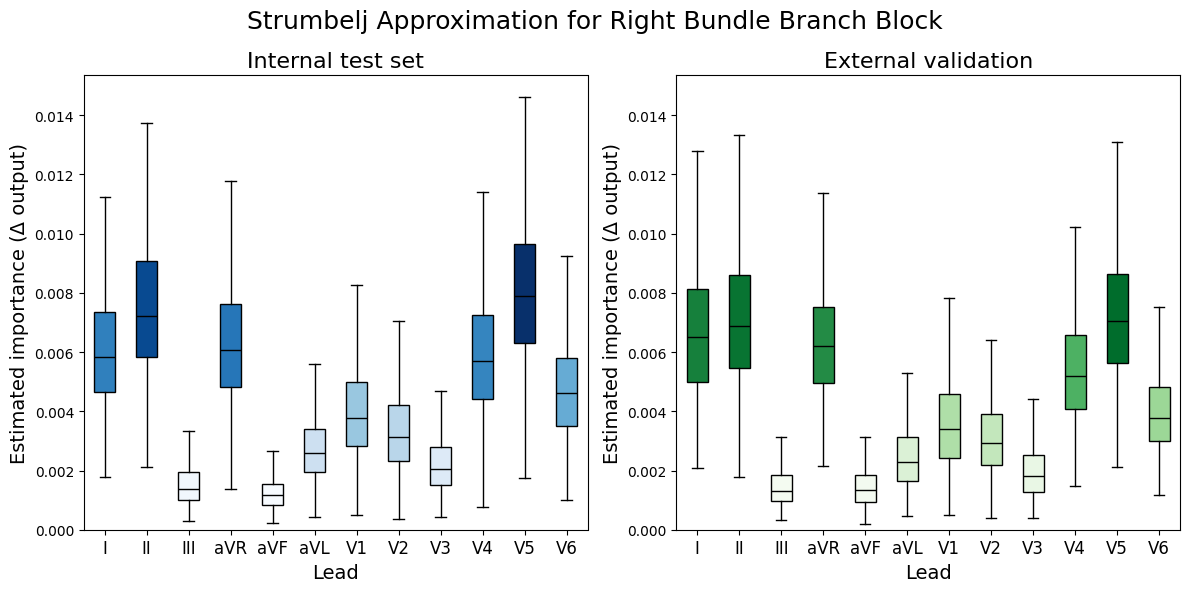

In [46]:
# plt.rcParams['text.usetex'] = True

lead_labels = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

# Create a boxplot
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
boxplt = ax[0].boxplot(phi_js_int, showfliers=False, patch_artist=True)


colors = [cmap_int.to_rgba(phi) for phi in median_phi_js_int]
for patch, color in zip(boxplt['boxes'], colors):
    patch.set_facecolor(color)

for median in boxplt['medians']:
    median.set_color('black')


ax[0].set_xticklabels(lead_labels, fontsize=12)
ax[0].set_ylabel('Estimated importance (Δ output)', fontsize=14)
ax[0].set_xlabel('Lead', fontsize=14)
ax[0].set_title(f'Internal test set', fontsize=16)

boxplt = ax[1].boxplot(phi_js_ext, showfliers=False, patch_artist=True)

colors = [cmap_ext.to_rgba(phi) for phi in median_phi_js_ext]
for patch, color in zip(boxplt['boxes'], colors):
    patch.set_facecolor(color)

for median in boxplt['medians']:
    median.set_color('black')

ax[1].set_xticklabels(lead_labels, fontsize=12)
ax[1].set_ylabel('Estimated importance (Δ output)', fontsize=14)
ax[1].set_xlabel('Lead', fontsize=14)
ax[1].set_title(f'External validation', fontsize=16)

# Get ylim
ylim_0 = ax[0].get_ylim()
ylim_1 = ax[1].get_ylim()
ylim = (0, max(ylim_0[1], ylim_1[1]))
ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)

condition_names_mapping = {
    'RBBB': 'Right Bundle Branch Block',
    'SVT': 'Supraventricular Tachycardia',
    'ST': 'Sinus Tachycardia',
    'AFIB': 'Atrial Fibrillation',
    'IDC': 'Interior differences conduction',
    'TWC': 'T-wave changes',
}

plt.suptitle(f'Strumbelj Approximation for {condition_names_mapping[OUTCOME]}', fontsize=18)

plt.tight_layout()
plt.savefig(f"{OUTCOME}_strumbelj_approximation.pdf", bbox_inches='tight')
plt.savefig(f"{OUTCOME}_strumbelj_approximation.png", bbox_inches='tight', dpi=600)
plt.show()

In [41]:
positive_patients = np.where(y_test_int[:,outcome_idx] == 1)[0]
positive_patients = np.random.choice(positive_patients, 20, replace=False)

preds = model.predict_on_batch(X_test_int[positive_patients])
baseline = preds[:, outcome_idx]

phi_js = np.zeros((len(positive_patients), 12))
for i, pt_idx in tqdm(enumerate(positive_patients), total=len(positive_patients)):
    phi_js[i, :] = Strumbelj_approximation(pt_idx, X_test_int, use_abs=False, n_samples=100)

baseline = model.predict(X_test_int)[:, outcome_idx].mean()
print(baseline)

100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


212/212 [==============================] - 1s 3ms/step
0.033780172


In [42]:
preds[:, outcome_idx]

array([6.5519720e-02, 3.3363408e-01, 2.8552026e-02, 2.9445759e-03,
       4.9944292e-04, 3.9550489e-01, 7.0190296e-02, 6.4405799e-02,
       7.8906871e-02, 4.1595104e-01, 9.8599419e-02, 3.1878799e-01,
       3.8491344e-01, 6.0682780e-01, 8.1234857e-02, 5.4255581e-01,
       1.2696213e-01, 3.7865019e-01, 8.4810950e-02, 3.1900036e-01],
      dtype=float32)

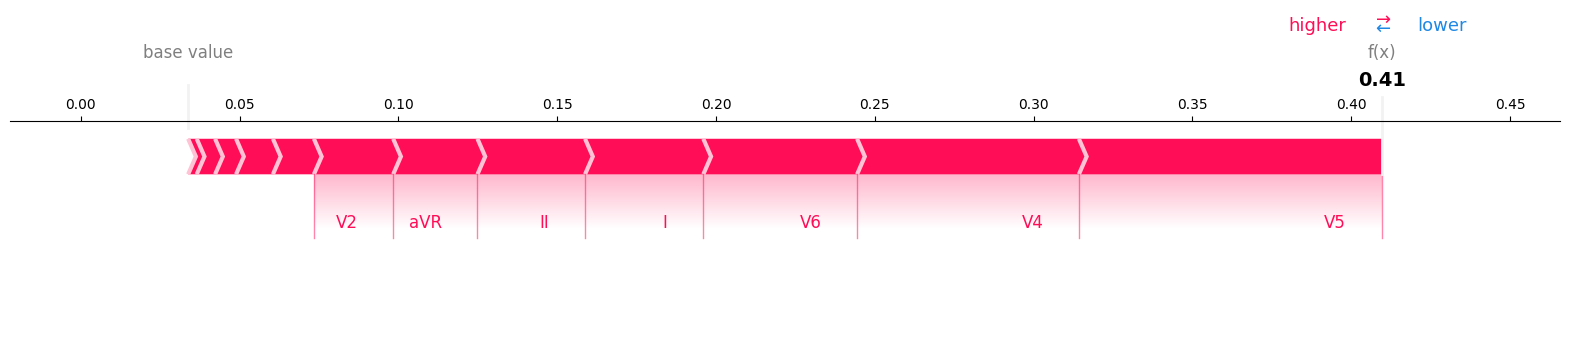

<Figure size 640x480 with 0 Axes>

In [81]:
import shap

sel = 5 # 11, 18
lead_labels = ['I', 'II', 'III', 'aVR', 'aVF', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

shap.force_plot(baseline, phi_js[sel,:], lead_labels, matplotlib=True)
plt.savefig('shap_force_plot.png')

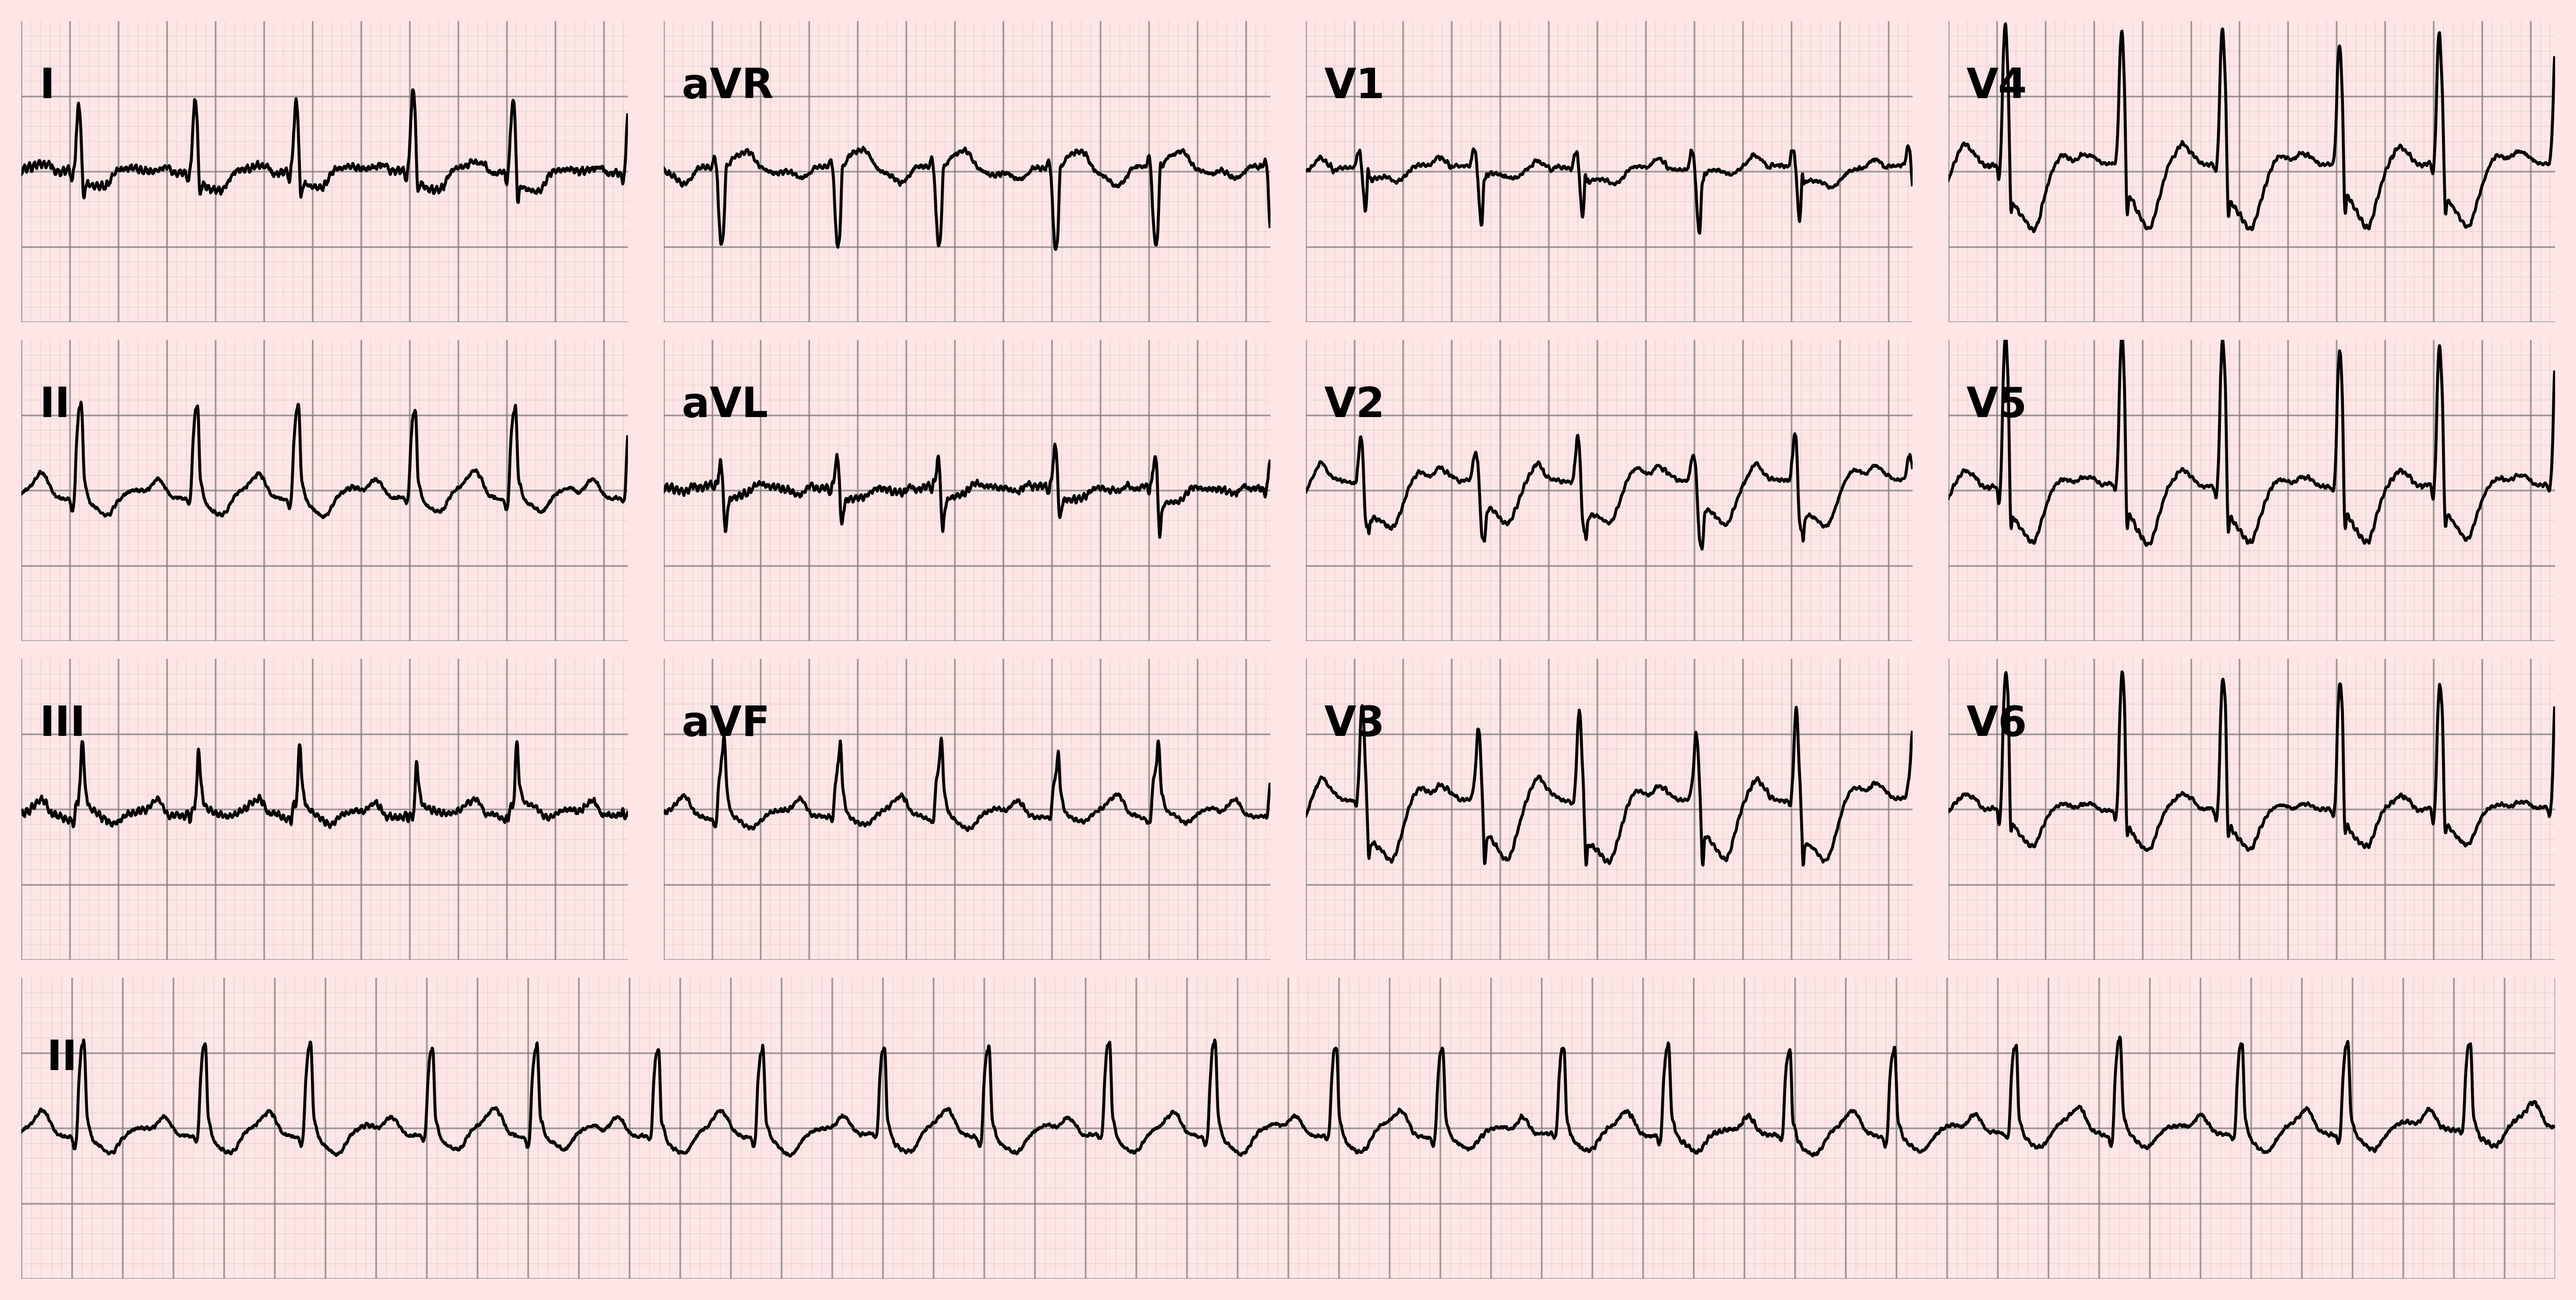

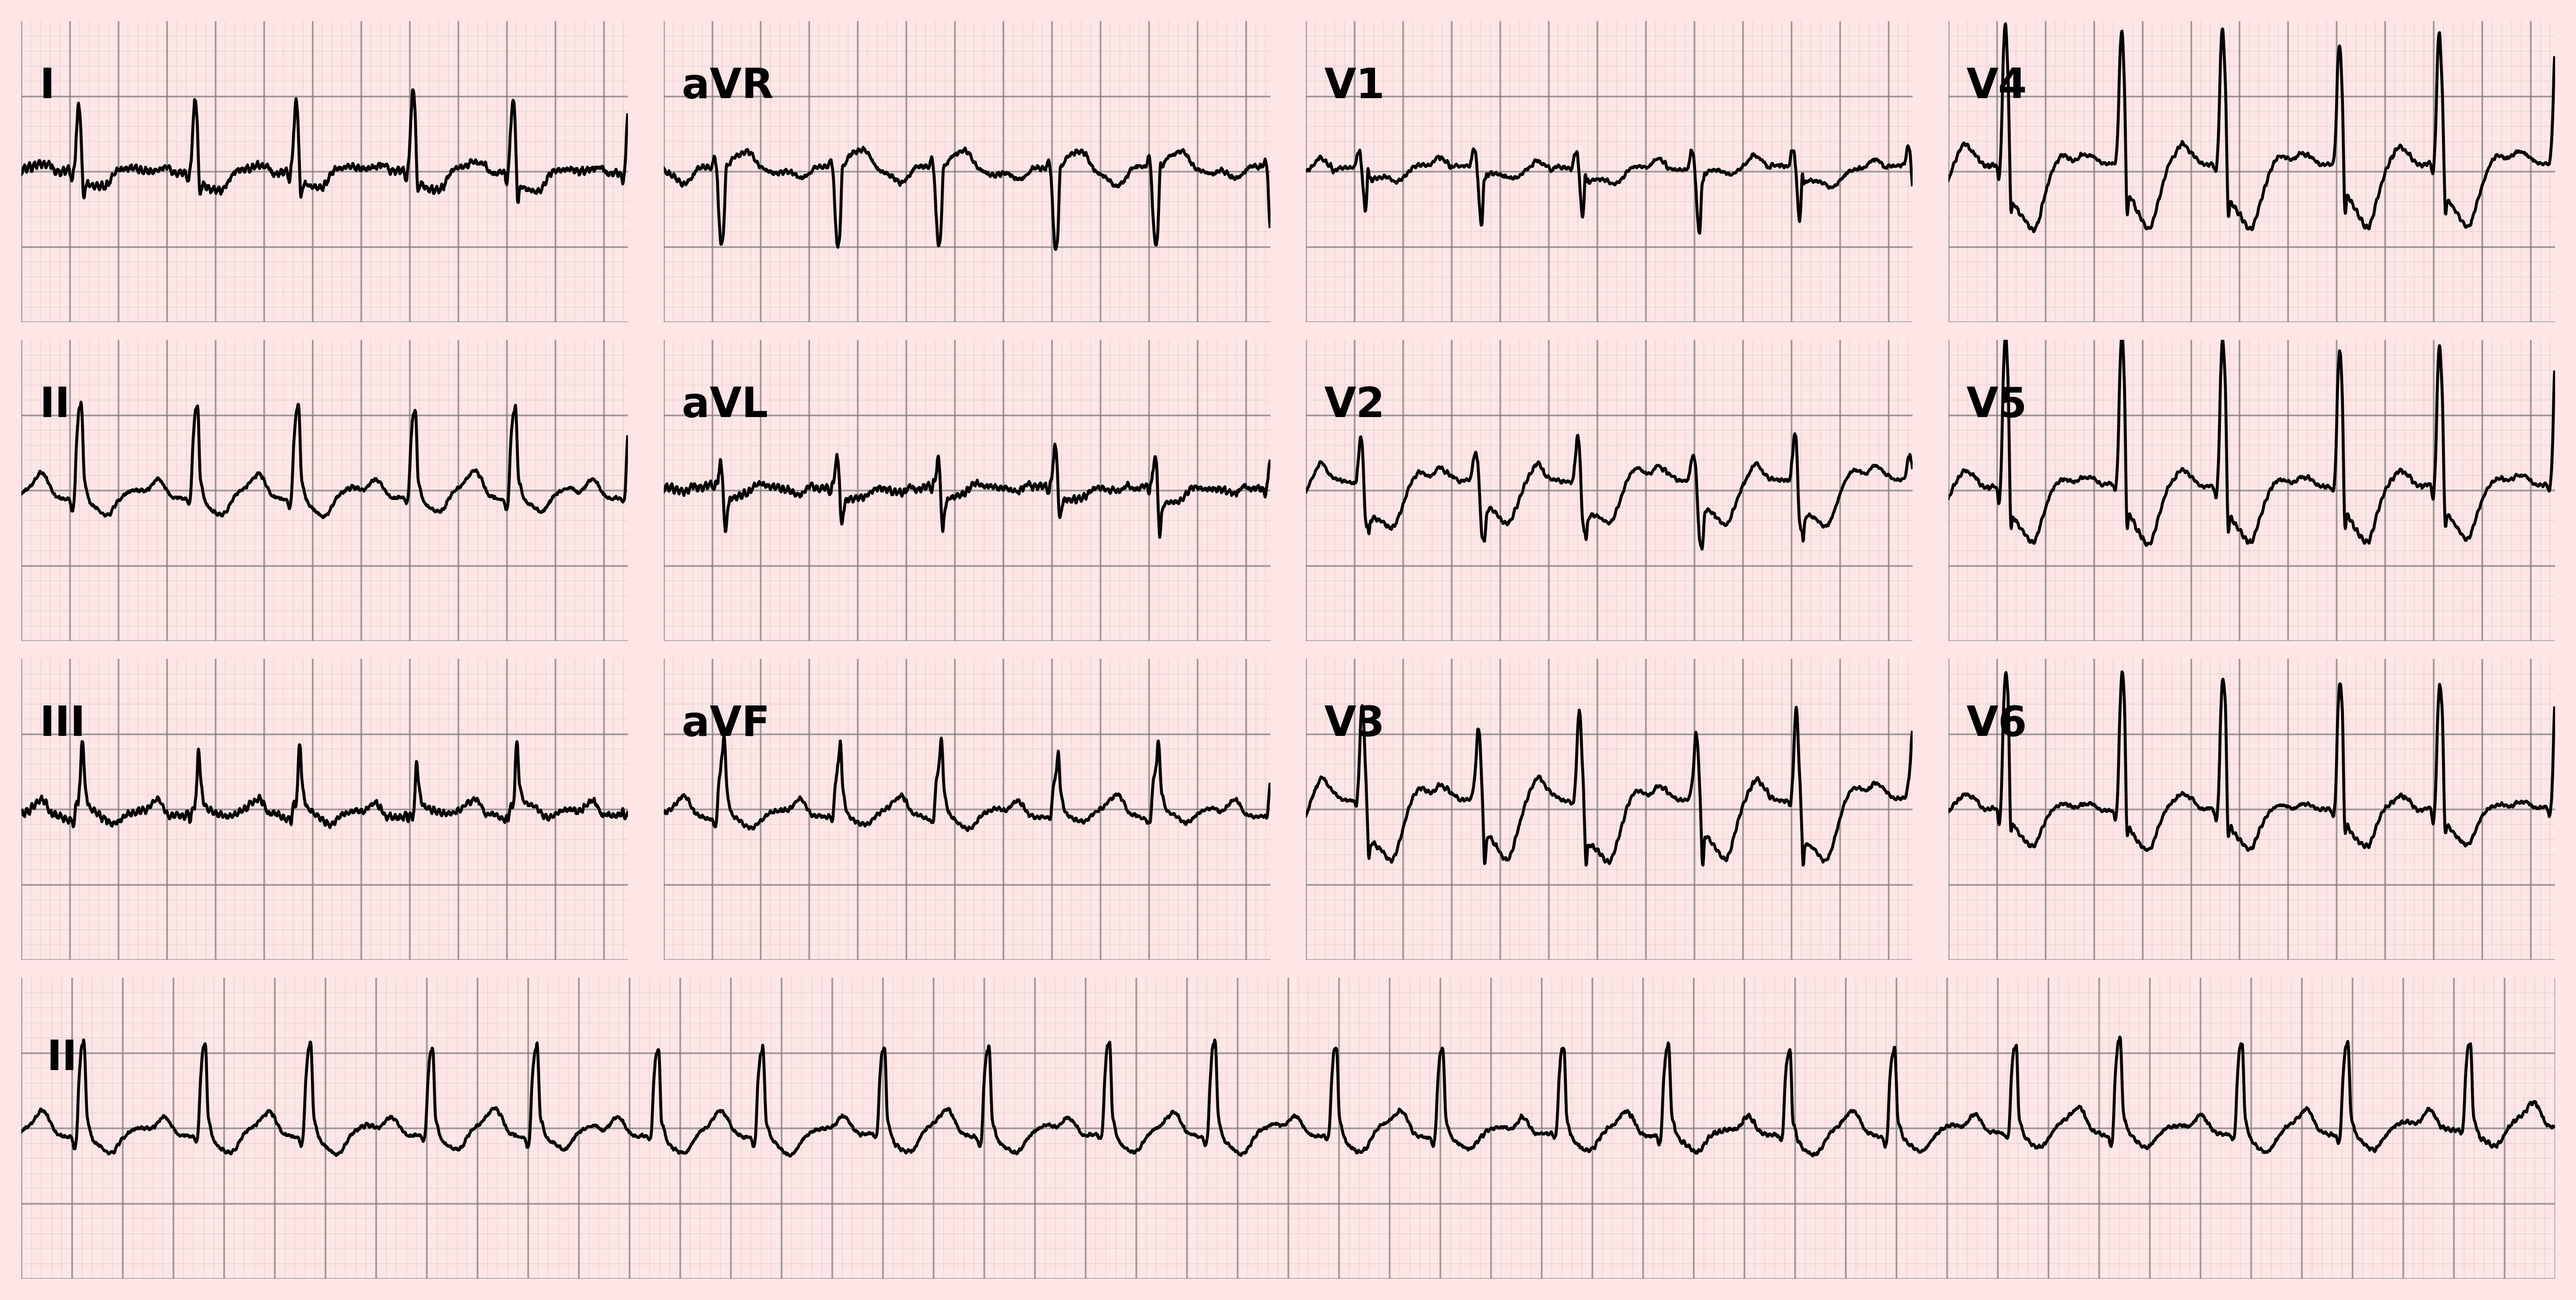

In [82]:
from plot_ecg import *

plot_ecg_strip(X_test_int[positive_patients[sel]])